### Notes and Refrences

This document explores a general process for loading, filtering, dimention reduction and clustering using PCA and K-means.

Evalutation is done with distence calculations and silhoutte analysis

See: 

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a


Drachen, A., Sifa, R., Bauckhage, C., & Thurau, C. (2012). Guns, swords and data: Clustering of player behavior in computer games in the wild. 2012 IEEE Conference on Computational Intelligence and Games (CIG), 163–170. https://doi.org/10.1109/CIG.2012.6374152


In [0]:

#@markdown ###First Cell 
#@markdown *Please paste this cell into any colab notebook for this project.* <br>
#@markdown ***
#@markdown **Contents**: Contents. <br>
#@markdown ***
#@markdown Major Edit History: 
#@markdown - Author, Date: Created as copy of Old Notebook (`Old Title`).
#@markdown ***
#@markdown <br> 
#@markdown Please change `FIELDDAY_DIR` if it is located differently in your drive. This cell will error if `FIELDDAY_DIR` is incorrect.
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# Change working directory
import os
FIELDDAY_DIR = '/content/drive/My Drive/Field Day' #@param {type:"string"}
JUPYTER_DIR = os.path.join(FIELDDAY_DIR,'Research and Writing Projects/2020 CHI Play - Lakeland Clustering/Jupyter')
os.chdir(JUPYTER_DIR)
print(f'---\nCWD: {os.getcwd()}')

#@markdown Change pandas `max_rows` and `max_columns`
import pandas as pd
pd.options.display.max_columns = 100 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

#@markdown *Note: There may be other variables to manually change. Look the "Set Variables" section.*

# import utils
import sys
sys.path.append('.')
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
---
CWD: /content/drive/My Drive/Field Day/Research and Writing Projects/2020 CHI Play - Lakeland Clustering/Jupyter


### Imports

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil
import numpy as np
pd.options.display.max_columns = 1000
from google.colab import files
import urllib.request
from zipfile import ZipFile
from io import BytesIO
import Notebooks.Clustering.cluster_utils as cu
import ipywidgets as widgets
import importlib
from scipy import stats
importlib.reload(cu)

<module 'Notebooks.Clustering.cluster_utils' from '/content/drive/My Drive/Field Day/Research and Writing Projects/2020 CHI Play - Lakeland Clustering/Jupyter/Notebooks/Clustering/cluster_utils.py'>

### Set Vars

In [0]:
options = None#cu.options.lakeland_player_lvl0
print(*str(options).split(','), sep='\n')

None


### Get Data

In [0]:
DecJanLogDF, import_meta = cu.getDecJanLogDF()
print(*import_meta,sep='\n')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1599) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Import from fhttps://github.com/fielddaylab/opengamedata/blob/master/jupyter/lakeland_data/LAKELAND_20191201_to_20191231_b2cf46d_proc.zip?raw=true
Import from fData/Raw Log Data/LAKELAND_20200101_to_20200131_a9720c1_proc.zip


In [0]:
print(DecJanLogDF.shape)
DecJanLogDF.head()

(32227, 1600)


lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     133            181.0             81.0   
19110007194177108 1                      91            172.0             56.0   
                  2                     184              NaN              NaN   
19110008292229944 1                     118            183.0            156.0   
19110008450097140 1                     272            246.0             12.0   

                            lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     NaN              NaN              NaN   
19110007194177108 1                     NaN              NaN              NaN   
                  2                     NaN              NaN              NaN   
19110008292229944 1                     NaN              NaN              NaN   
19110008450097140 1                     NaN              NaN              NaN   

                            lvl6_EventCount  lvl7_EventCount  lvl8_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     NaN              NaN              NaN   
19110007194177108 1                     NaN              NaN              NaN   
                  2                     NaN              NaN              NaN   
19110008292229944 1                     NaN              NaN              NaN   
19110008450097140 1                     NaN              NaN              NaN   

                            lvl9_EventCount  lvl0_ActiveEventCount  \
sessID            num_play                                           
19110002150060536 1                     NaN                   77.0   
19110007194177108 1                     NaN                   51.0   
                  2                     NaN                   50.0   
19110008292229944 1                     NaN                   37.0   
19110008450097140 1                     NaN                   42.0   

                            lvl1_ActiveEventCount  lvl2_ActiveEventCount  \
sessID            num_play                                                 
19110002150060536 1                         103.0                   35.0   
19110007194177108 1                          91.0                   26.0   
                  2                           NaN                    NaN   
19110008292229944 1                          65.0                   60.0   
19110008450097140 1                          25.0                    NaN   

                            lvl3_ActiveEventCount  lvl4_ActiveEventCount  \
sessID            num_play                                                 
19110002150060536 1                           NaN                    NaN   
19110007194177108 1                           NaN                    NaN   
                  2                           NaN                    NaN   
19110008292229944 1                           NaN                    NaN   
19110008450097140 1                           NaN                    NaN   

                            lvl5_ActiveEventCount  lvl6_ActiveEventCount  \
sessID            num_play                                                 
19110002150060536 1                           NaN                    NaN   
19110007194177108 1                           NaN                    NaN   
                  2                           NaN                    NaN   
19110008292229944 1                           NaN                    NaN   
19110008450097140 1                           NaN                    NaN   

                            lvl7_ActiveEventCount  lvl8_ActiveEventCount  \
sessID            num_play                                                 
19110002150060536 1                           NaN                    NaN   
191100

### Filter

In [0]:
if options and options.filter_args is not None:
    filtered_df, filter_meta = cu.filter_df(DecJanLogDF, **options.filter_args)
else:
    filtered_df, filter_meta = cu.filter_df(DecJanLogDF, query_list=[], verbose=False, fillna=0)

print(*filter_meta,sep='\n')
filtered_df

*arg* filter_args = {'one_query': False, 'cont': False, 'max_sessDuration': None, 'min_sessDuration': 300, 'min_lvlend_ActiveEventCount': 3, 'min_lvlstart_ActiveEventCount': 3, 'min_sessActiveEventCount': 10, 'no_debug': True, 'lvlend': None, 'lvlstart': None, 'only_query_list': False, 'query_list': [], 'fillna': 0, 'verbose': False}
Query: Intial Shape, output_shape: (32227, 1600)
Query: debug == 0, output_shape: (32221, 1600)
Query: sess_ActiveEventCount >= 10, output_shape: (26935, 1600)
Query: sessDuration >= 300, output_shape: (16110, 1600)
Query: _continue == 0, output_shape: (10592, 1600)
Filled NaN with 0


lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     133            181.0             81.0   
19110007194177108 1                      91            172.0             56.0   
19110008292229944 1                     118            183.0            156.0   
19110009364430810 2                     476            194.0              0.0   
19110009492236160 1                      69             76.0             88.0   
...                                     ...              ...              ...   
20000623064839788 1                      68             70.0              0.0   
20000623254750504 3                     139            162.0              9.0   
20010608100268980 1                      65            117.0             94.0   
20010608250817020 1                       2             83.0             21.0   
20010614191119680 1                     116             80.0            102.0   

                            lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     0.0              0.0              0.0   
19110007194177108 1                     0.0              0.0              0.0   
19110008292229944 1                     0.0              0.0              0.0   
19110009364430810 2                     0.0              0.0              0.0   
19110009492236160 1                    74.0             70.0              0.0   
...                                     ...              ...              ...   
20000623064839788 1                     0.0              0.0              0.0   
20000623254750504 3                     0.0              0.0              0.0   
20010608100268980 1                     0.0              0.0              0.0   
20010608250817020 1                     0.0              0.0              0.0   
20010614191119680 1                    81.0              0.0              0.0   

                            lvl6_EventCount  lvl7_EventCount  lvl8_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     0.0              0.0              0.0   
19110007194177108 1                     0.0              0.0              0.0   
19110008292229944 1                     0.0              0.0              0.0   
19110009364430810 2                     0.0              0.0              0.0   
19110009492236160 1                     0.0              0.0              0.0   
...                                     ...              ...              ...   
20000623064839788 1                     0.0              0.0              0.0   
20000623254750504 3                     0.0              0.0              0.0   
20010608100268980 1                     0.0              0.0              0.0   
20010608250817020 1                     0.0              0.0              0.0   
20010614191119680 1                     0.0              0.0              0.0   

                            lvl9_EventCount  lvl0_ActiveEventCount  \
sessID            num_play                                           
19110002150060536 1                     0.0                   77.0   
19110007194177108 1                     0.0                   51.0   
19110008292229944 1                     0.0                   37.0   
19110009364430810 2                     0.0                   60.0   
19110009492236160 1                     0.0                   29.0   
...                                     ...                    ...   
20000623064839788 1                     0.0                   16.0   
20000623254750504 3                     0.0                   45.0   
20010608100268980 1                     0.0                   26.0   
20010608250817020 1                     0.0                    0.0   
20010614191119680 1       

### Create New Features



In [0]:
if options and options.new_feat_args is not None:
    new_feat_df, new_feat_meta = cu.create_new_base_features(filtered_df, **options.new_feat_args)
else:
    new_feat_df, new_feat_meta = cu.create_new_base_features(filtered_df, avg_tile_hover_lvl_range=range(0,2))
print(*new_feat_meta,sep='\n')
new_feat_df

*arg* new_feat_args = {'avg_tile_hover_lvl_range': range(0, 2), 'verbose': False}


lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     133            181.0             81.0   
19110007194177108 1                      91            172.0             56.0   
19110008292229944 1                     118            183.0            156.0   
19110009364430810 2                     476            194.0              0.0   
19110009492236160 1                      69             76.0             88.0   
...                                     ...              ...              ...   
20000623064839788 1                      68             70.0              0.0   
20000623254750504 3                     139            162.0              9.0   
20010608100268980 1                      65            117.0             94.0   
20010608250817020 1                       2             83.0             21.0   
20010614191119680 1                     116             80.0            102.0   

                            lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     0.0              0.0              0.0   
19110007194177108 1                     0.0              0.0              0.0   
19110008292229944 1                     0.0              0.0              0.0   
19110009364430810 2                     0.0              0.0              0.0   
19110009492236160 1                    74.0             70.0              0.0   
...                                     ...              ...              ...   
20000623064839788 1                     0.0              0.0              0.0   
20000623254750504 3                     0.0              0.0              0.0   
20010608100268980 1                     0.0              0.0              0.0   
20010608250817020 1                     0.0              0.0              0.0   
20010614191119680 1                    81.0              0.0              0.0   

                            lvl6_EventCount  lvl7_EventCount  lvl8_EventCount  \
sessID            num_play                                                      
19110002150060536 1                     0.0              0.0              0.0   
19110007194177108 1                     0.0              0.0              0.0   
19110008292229944 1                     0.0              0.0              0.0   
19110009364430810 2                     0.0              0.0              0.0   
19110009492236160 1                     0.0              0.0              0.0   
...                                     ...              ...              ...   
20000623064839788 1                     0.0              0.0              0.0   
20000623254750504 3                     0.0              0.0              0.0   
20010608100268980 1                     0.0              0.0              0.0   
20010608250817020 1                     0.0              0.0              0.0   
20010614191119680 1                     0.0              0.0              0.0   

                            lvl9_EventCount  lvl0_ActiveEventCount  \
sessID            num_play                                           
19110002150060536 1                     0.0                   77.0   
19110007194177108 1                     0.0                   51.0   
19110008292229944 1                     0.0                   37.0   
19110009364430810 2                     0.0                   60.0   
19110009492236160 1                     0.0                   29.0   
...                                     ...                    ...   
20000623064839788 1                     0.0                   16.0   
20000623254750504 3                     0.0                   45.0   
20010608100268980 1                     0.0                   26.0   
20010608250817020 1                     0.0                    0.0   
20010614191119680 1       

### Optional: Select Level Features to Aggregate
Ignore the 'sess' and 'other' columns.<br>
Or choose to use hardcoded options

In [0]:
if not options: #options.lvlfeats is not None and options.lvlrange is not None:
    level_features_widget = cu.get_feat_selection(new_feat_df)
    display(level_features_widget)

GridBox(children=(VBox(children=(Text(value='', description='Search lvl:', layout=Layout(width='400px')), VBox…

### Select final features

In [0]:
if options:# and options.lvlfeats is not None and options.lvlrange is not None: 
    aggregate_df, aggregate_meta = cu.describe_lvl_feats(new_feat_df, options.lvlfeats, options.lvlrange)
else:
    lvl_feats, lvl_range = cu.get_level_feats_and_range(level_features_widget)
    aggregate_df, aggregate_meta = cu.describe_lvl_feats(new_feat_df, lvl_feats, lvl_range)
# if not options:# and options.finalfeats is not None:
    final_features_widget = cu.get_feat_selection(aggregate_df)
    display(final_features_widget)
print(*aggregate_meta,sep='\n')

/content/drive/My Drive/Field Day/Research and Writing Projects/2020 CHI Play - Lakeland Clustering/Jupyter/Notebooks/Clustering/cluster_utils.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sum_prefix+fn] = tdf.sum(axis=1)
/content/drive/My Drive/Field Day/Research and Writing Projects/2020 CHI Play - Lakeland Clustering/Jupyter/Notebooks/Clustering/cluster_utils.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[avg_prefix+fn] = tdf.mean(axis=1)


GridBox(children=(VBox(children=(Text(value='', description='Search lvl:', layout=Layout(width='400px')), VBox…

*arg* lvlfeats = ['avg_distance_between_poop_placement_and_lake', 'count_buy_skimmer']
*arg* lvlrange = range(0, 6)
Describe Level Feats lvls 0 to 5. Assuming WINDOW_SIZE_SECONDS=300 and WINDOW_OVERLAP_SECONDS=30, filtered by (sessDuration > 1650)


### Output final columns

In [0]:
if options: #None not in [options, options.finalfeats]:
    reduced_df, reduced_meta = cu.reduce_feats(aggregate_df, options.finalfeats)
else:
    final_feats = cu.get_selected_feature_list(final_features_widget)
    reduced_df, reduced_meta = cu.reduce_feats(aggregate_df, final_feats)
print(*reduced_meta, sep='\n')
reduced_df

*arg* finalfeats = ['sess_avg_num_tiles_hovered_before_placing_road']


sess_avg_num_tiles_hovered_before_placing_road
sessID            num_play                                                
19110010481226510 2                                                    0.0
19110013230776100 1                                                    0.0
19110013555688148 1                                                    0.0
19110014422132304 1                                                    0.0
19110016080539144 1                                                    0.0
...                                                                    ...
20000618530751176 1                                                    0.0
20000619253338828 1                                                    0.0
20000619434010530 2                                                    0.0
20000621004264310 1                                                    0.0
20000621345495548 1                                                    0.0

[1354 rows x 1 columns]

In [0]:
reduced_df.describe()

lvl4_avg_distance_between_poop_placement_and_lake  \
count                                        1354.000000   
mean                                            0.855993   
std                                             0.771037   
min                                             0.000000   
25%                                             0.000000   
50%                                             1.108460   
75%                                             1.495349   
max                                             2.601936   

       sum_lvl_0_to_5_avg_distance_between_poop_placement_and_lake  
count                                        1354.000000            
mean                                            5.500107            
std                                             3.409183            
min                                             0.000000            
25%                                             2.738225            
50%                                             5.769221            
75%                                             8.172467            
max                                            15.422946

Import from fhttps://github.com/fielddaylab/opengamedata/blob/master/jupyter/lakeland_data/LAKELAND_20191201_to_20191231_b2cf46d_proc.zip?raw=true
Import from fData/Raw Log Data/LAKELAND_20200101_to_20200131_a9720c1_proc.zip
*arg* filter_args = {'one_query': False, 'cont': False, 'max_sessDuration': None, 'min_sessDuration': 300, 'min_lvlend_ActiveEventCount': 3, 'min_lvlstart_ActiveEventCount': 3, 'min_sessActiveEventCount': 10, 'no_debug': True, 'lvlend': None, 'lvlstart': None, 'only_query_list': False, 'query_list': [], 'fillna': 0, 'verbose': False}
Query: Intial Shape, output_shape: (32227, 1600)
Query: debug == 0, output_shape: (32221, 1600)
Query: sess_ActiveEventCount >= 10, output_shape: (26935, 1600)
Query: sessDuration >= 300, output_shape: (16110, 1600)
Query: _continue == 0, output_shape: (10592, 1600)
Filled NaN with 0
*arg* new_feat_args = {'avg_tile_hover_lvl_range': range(0, 2), 'verbose': False}
*arg* lvlfeats = ['avg_distance_between_poop_placement_and_lake', 'count

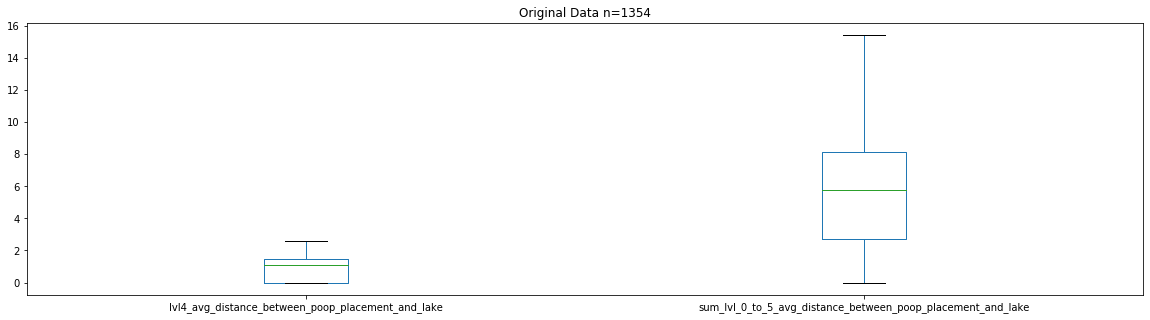

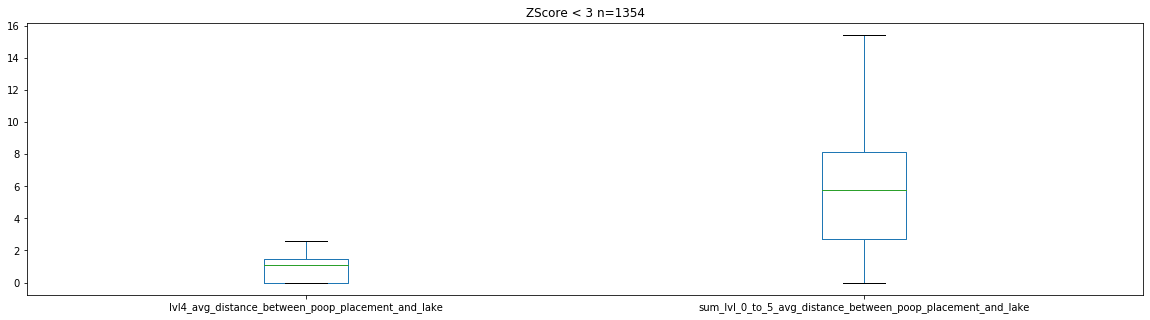

In [0]:
if not options:
    final_df, outlier_meta = cu.reduce_outliers(reduced_df, 3)
else:
    final_df, outlier_meta = cu.reduce_outliers(reduced_df, options.zthresh)
final_meta = import_meta + filter_meta + new_feat_meta + aggregate_meta + reduced_meta + outlier_meta
print(*final_meta, sep='\n')

In [0]:
cu.print_options(final_meta)

options('GAME',
	'NAME',
	{'one_query': False, 'cont': False, 'max_sessDuration': None, 'min_sessDuration': 300, 'min_lvlend_ActiveEventCount': 3, 'min_lvlstart_ActiveEventCount': 3, 'min_sessActiveEventCount': 10, 'no_debug': True, 'lvlend': None, 'lvlstart': None, 'only_query_list': False, 'query_list': [], 'fillna': 0, 'verbose': False},
	{'avg_tile_hover_lvl_range': range(0, 2), 'verbose': False},
	['avg_distance_between_poop_placement_and_lake', 'count_buy_skimmer'],
	range(0, 6),
	['lvl4_avg_distance_between_poop_placement_and_lake', 'sum_lvl_0_to_5_avg_distance_between_poop_placement_and_lake'],
	3,
	[]
)
